In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

# Implementing a solver for the advection equation

We're going to write all the necessary objects to solve the following equation:

\begin{equation}
    \partial_t \varphi + \mathbf{u} \cdot \nabla \varphi = 0
\end{equation}

That, compared to our generalized model:
\begin{equation}
    \partial_t \mathbf{q} + 
    \nabla \cdot \left(\underline{\underline{\mathbf{F}}}(\mathbf{q}) 
        + \underline{\underline{\underline{\underline{D(\mathbf{q})}}}} \cdot \nabla \mathbf{q} \right) +
    \underline{\underline{\underline{\mathbf{B}(\mathbf{q})}}} \cdot \nabla\mathbf{q} = 
    \mathbf{s}(\mathbf{q})
\end{equation}

Gives $\mathbf{q} = \left\{\varphi\right\}$
$\mathbf{F} = \underline{\underline{\mathbf{0}}}$, 
$\mathbf{D} = \underline{\underline{\underline{\underline{\mathbf{0}}}}}$

So our problem needs just to provide $\mathbf{B}$.
\begin{equation}
    B_{pqr} = u_r
\end{equation}

## `State`

In [2]:
from josie.solver.state import State
from enum import IntEnum

class AdvectionFields(IntEnum):
    phi = 0
    
class AdvectionState(State):
    fields = AdvectionFields

## `Problem`

We just need to implement the $\mathbf{B}(\mathbf{q})$ operator

In [3]:
from josie.solver.problem import Problem

Problem??

In [4]:
from josie.mesh.cellset import CellSet, MeshCellSet

class AdvectionProblem(Problem):
    V = np.array([1, 0])
    
    DIMENSIONALITY = 2 ## 2D
    
    def B(self, cells: CellSet):
        values: AdvectionState = cells.values
        nx, ny, num_fields = values.shape
        fields = values.fields
        
        B = np.zeros((nx, ny, num_fields, num_fields, self.DIMENSIONALITY))
        
        B[..., fields.phi, fields.phi, : ] = self.V
        
        return B

## `Scheme`
cell_scheme

We just need to implement the 
\begin{equation}
    \mathbf{G}_{\frac{1}{2}}(\mathbf{q}) = 
    \left| \mathbf{q}\hat{\mathbf{n}} \right|_f S_f \Rightarrow
    \left| \varphi \hat{\mathbf{n}}\right|_f S_f 
\end{equation}

In [5]:
from josie.solver.scheme.nonconservative import NonConservativeScheme

NonConservativeScheme??

In [6]:

class Upwind(NonConservativeScheme):
    def G(self, cells: MeshCellSet, neighs: CellSet):
        V = self.problem.V
        
        # Get the normal velocities (that are equal everywhere) per each cell
        Vn = np.einsum("k,...kl->...l", V, neighs.normals[..., np.newaxis])
        
        values_face = np.zeros_like(cells.values)
        
        # We use the cell value where Vn > 0 
        np.copyto(values_face, cells.values, where=(Vn>0))
        
        # We use the neighbour value otherwise
        np.copyto(values_face, neighs.values, where=(Vn<=0))
        
        # Multiply by the normal 
        valuesn_face = np.einsum("...i,...j->...ij", values_face, neighs.normals)
        
        # Multiply by the surface
        G = valuesn_face * neighs.surfaces[..., np.newaxis, np.newaxis]
        
        return G

## `Mesh`
We generated a 1D mesh

In [7]:
from josie.boundary import Line

left = Line([0, 0], [0, 1])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

We apply periodic boundary condition along the x-axis (no BC on y-axis since it's a 1D simulation)

In [8]:
from josie.bc import make_periodic, Direction

left, right = make_periodic(left, right, Direction.X)
top.bc = None
bottom.bc = None

In [9]:
from josie.mesh import Mesh
from josie.mesh.cell import SimpleCell
mesh = Mesh(left, bottom, right, top, SimpleCell)
mesh.interpolate(300, 1)
mesh.generate()

## `Solver`

Let's assemble our scheme, that still needs the time scheme, and a CFL method

In [10]:
from josie.general.schemes.time import ExplicitEuler

class AdvectionScheme(Upwind, ExplicitEuler):
    def CFL(
        self,
        cells: MeshCellSet,
        CFL_value: float,
    ) -> float:

        U_abs = np.linalg.norm(self.problem.V)
        dx = np.min(cells.surfaces)

        return CFL_value * dx / U_abs


scheme = AdvectionScheme(AdvectionProblem())


In [11]:
from josie.solver.solver import Solver

solver = Solver(mesh, AdvectionState, scheme)

We need now to define an initialization function to initialize the domain

In [12]:
def init_fun(cells: MeshCellSet):
    xc = cells.centroids[..., 0]

    xc_r = np.where(xc >= 0.5)
    xc_l = np.where(xc < 0.5)

    cells.values[xc_r[0], xc_r[1], ...] = 1
    cells.values[xc_l[0], xc_l[1], ...] = 0

### Run the simulation

Let's initialize the solver state

In [13]:
solver.init(init_fun)

# Plotting stuff
import matplotlib.pyplot as plt
import copy

from matplotlib.animation import ArtistAnimation
solution = []

t = 0
final_time = 1
CFL = 0.5

Let's iterate in time choosing a time-based writing strategy (save every $0.01s$) to memory

In [14]:
from josie.io.write.strategy import TimeStrategy
from josie.io.write.writer import MemoryWriter 

strategy = TimeStrategy(dt_save=0.01)
writer = MemoryWriter(strategy, solver, final_time, CFL)
writer.solve()

<IPython.core.display.Javascript object>


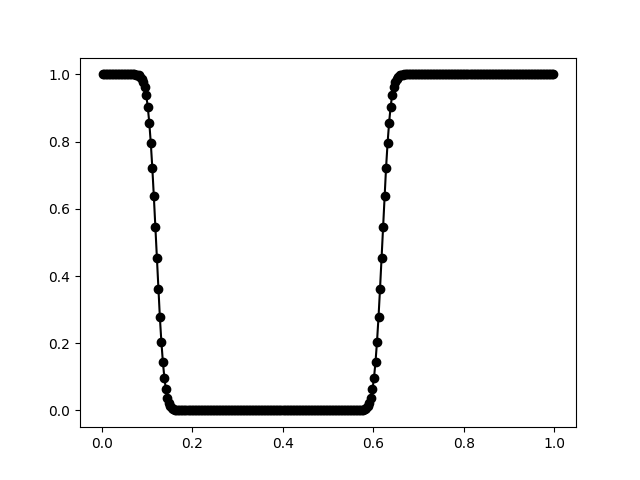

In [18]:
fig, ax = plt.subplots()
ims = []

for solution in writer.data:
    cells = solution.mesh.cells
    x = cells.centroids[..., 0]
    x = x.reshape(x.size)
    phi = cells.values[..., AdvectionFields.phi]
    (im,) = ax.plot(x, phi, 'ko-')
    ims.append([im])
    
    
ani = ArtistAnimation(fig, ims, interval=50)